<a id=top></a>
# Viewing STIS Data

## Learning Goals
By the end of this tutorial, you will go through: 
- [0.Introduction](#section0)
 - [0.1 Import necessary packages](#section0.1) 
- [1. Downloading STIS data from MAST using astroquery](#section1) 
- [2. Reading in the data](#section2)
 - [2.1 Investigating the data - Basics](#section2.1)
 - [2.2 Reading the table data](#section2.2)
- [3. Plotting the spectrum](#section3)
 - [3.1 Making a simple plot of the spectrum](#section3.1)
- [4. Working with data quality flags](#section4)
 - [4.1 Data quality frequencies histogram](#section4.1)
 - [4.2 Removing "Serious Data Quality"](#section4.2)
- [5. Visualizing STIS Image](#section5)
 - [5.1 Exploring image file structure](#section5.1)
 - [5.2 Showing the image](#section5.2)
 - [5.3 Removing serious data quality pixels](#section5.3)
- [6.Working with Time-Tag Data](#section6)
 - [6.1 Investigating the _tag Data](#section6.1)
 - [6.2 Converting Time_Tag into ACCUM image](#section6.2)

<a id=section0></a>
## 0. Introduction

**The Space Telescope Imaging Spectrograph (STIS) is a versatile imaging spectrograph installed on the Hubble Space Telescope ([HST](https://www.stsci.edu/hst/about)), covering a wide range of wavelengths from the near-infrared region into the ultraviolet.**

**This tutorial aims to prepare new users to begin analyzing STIS Data by going through downloading data, reading and viewing spectrum, and viewing STIS image.**

**There are three detectors on STIS: FUV-MAMA, NUV-MAMA, and CCD. While the detectors are designed for different scientific purposes and operate at different wavelength, their data are organized in the same structure. Thus we are using NUV-MAMA data as an example in this notebook, and leave the rest as exercises to the users.**

For detailed overview of the STIS instrument, see the [STIS Instrument Handbook](https://hst-docs.stsci.edu/stisihb). \
For more information on STIS data analysis and operations, see the [STIS Data Handbook](https://hst-docs.stsci.edu/stisdhb).

**Defining some terms:**

* **HST:** Hubble Space Telescope
* **STIS:** Space Telescope Imaging Spectrograph on HST (https://www.stsci.edu/hst/instrumentation/stis)
* **STIS/NUV-MAMA:** Cs2Te Multi-Anode Microchannel Array (MAMA) detector
* **STIS/FUV-MAMA:** Solar-blind CsI Multi-Anode Microchannel Array (MAMA) detector
* **CCD:** Charge Coupled Device 
* **FITS:** Flexible Image Transport System (https://fits.gsfc.nasa.gov/fits_primer.html)
* **HDU:** Header/Data Unit in a FITS file

<a id=section0.1></a>
### 0.1 Import necessary packages

**We will import the following packages:**

- `astropy.io fits` for accessing FITS files
- `astropy.table Table` for creating tidy tables of the data
- `astroquery.mast Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive
- `pathlib` for managing system paths
- `matplotlib.pyplot` for plotting data
- `IPython.display` for formatting display
- `numpy` to handle array functions
- `pandas` to make basic tables and dataframes
- `stistools` for quick operations on STIS Data

In [1]:
# Import for: Reading in fits file
from astropy.table import Table
from astropy.io import fits

# Import for: Downloading necessary files. (Not necessary if you choose to collect data from MAST)
from astroquery.mast import Observations

# Import for: Managing system variables and paths
from pathlib import Path

# Import for: Plotting and specifying plotting parameters
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display

# Import for: Quick Calculation and Data Analysis
import numpy as np
import pandas as pd

# Import for operations on STIS Data
import stistools

/Users/kding/miniconda3/envs/stis/lib/python3.7/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/Users/kding/miniconda3/envs/stis/lib/python3.7/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


<a id=section1></a>
## 1. Downloading STIS data from [MAST](https://archive.stsci.edu/) using [`astroquery`](https://astroquery.readthedocs.io/en/latest/)
There are other ways to download data from MAST such as using CyberDuck. We are only showing how to use astroquery in this notebook

In [2]:
# make directory for downloading data
datadir = Path('./data')
datadir.mkdir(exist_ok=True)

In [3]:
# Search target objscy by obs_id
target = Observations.query_criteria(obs_id='odgxt9010')
# get a list of files assiciated with that target
NUV_list = Observations.get_product_list(target)
# Download only the SCIENCE fits files
Observations.download_products(NUV_list,productType="SCIENCE",extension='fits',download_dir=str(datadir))

INFO: Found cached file data/mastDownload/HST/odgxt9010/odgxt9010_raw.fits with expected size 16819200. [astroquery.query]
INFO: Found cached file data/mastDownload/HST/odgxt9010/odgxt9010_x1d.fits with expected size 77760. [astroquery.query]
INFO: Found cached file data/mastDownload/HST/odgxt9010/odgxt9010_x2d.fits with expected size 14474880. [astroquery.query]
INFO: Found cached file data/mastDownload/HST/odgxt9010/odgxt9010_flt.fits with expected size 10535040. [astroquery.query]


Local Path,Status,Message,URL
str50,str8,object,object
data/mastDownload/HST/odgxt9010/odgxt9010_raw.fits,COMPLETE,None,None
data/mastDownload/HST/odgxt9010/odgxt9010_x1d.fits,COMPLETE,None,None
data/mastDownload/HST/odgxt9010/odgxt9010_x2d.fits,COMPLETE,None,None
data/mastDownload/HST/odgxt9010/odgxt9010_flt.fits,COMPLETE,None,None


<a id=section2></a>
## 2. Reading in the data

<a id=section2.1></a>
### 2.1 Investigating the data - Basics
Before doing any operation on the data, we want to first explore the basics and data file structures.

The Aperture extracted, background subtracted, flux and wavelength calibrated spectra data is stored in fits file with suffix _x1d. While we are using _x1d fits file as an example of investigating STIS table data, the following method of reading in data and viewing spectrum or other fields can be applied to any table data, either calibrated or uncalibrated. For more information on STIS file naming conventions, see [Types of STIS Files](https://hst-docs.stsci.edu/stisdhb/chapter-2-stis-data-structure/2-2-types-of-stis-files).

Open the x1d fits file and explore its info and header:

In [4]:
#get information about the fits file
x1d_file=Path("./data/mastDownload/HST/odgxt9010/odgxt9010_x1d.fits")
fits.info(x1d_file)

Filename: data/mastDownload/HST/odgxt9010/odgxt9010_x1d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     278   ()      
  1  SCI           1 BinTableHDU    156   1R x 19C   [1I, 1I, 1024D, 1024E, 1024E, 1024E, 1024E, 1024E, 1024E, 1024I, 1E, 1E, 1I, 1E, 1E, 1E, 1E, 1024E, 1E]   


The primary header that stores keyword information describing the global properties of all of the exposures in the file 

In [5]:
#get header of the fits file
x1d_header_0 = fits.getheader(x1d_file,0)

try:
    print(x1d_header_0["instrument"])
except KeyError:
    print(x1d_header_0["primesi"])
for key in ["detector","obsmode", "opt_elem", "targname"]:
    print("{0}: {1}".format(key, x1d_header_0[key]))
print()   

STIS
detector: NUV-MAMA
obsmode: TIME-TAG
opt_elem: G230M
targname: V-T-CRA



You can change the keys to check for other fields and metadata, or directly print the x1d_header to get all header information.

Some other metadata, such as exposure data and time, are stored in the first extension.

In [6]:
x1d_header_1 = fits.getheader(x1d_file,1)

date = x1d_header_1["DATE-OBS"]
time = x1d_header_1["Time-OBS"]
exptime = x1d_header_1["EXPTIME"]

print("The data were taken on {d}, starting at {t}, with the exposure time of {e} seconds".format(d=date,t=time,e=exptime))

The data were taken on 2020-03-19, starting at 13:23:24, with the exposure time of 2380.199375 seconds


<a id=section2.2></a>
### 2.2 Reading the table data
The main science data is stored at the first extension of the x1d fits file. We first read in the data as an astropy table.

In [7]:
#get data
x1d_data = Table.read(x1d_file,1)
# Display a representation of the data table:
x1d_data

SPORDER,NELEM,WAVELENGTH [1024],GROSS [1024],BACKGROUND [1024],NET [1024],FLUX [1024],ERROR [1024],NET_ERROR [1024],DQ [1024],A2CENTER,EXTRSIZE,MAXSRCH,BK1SIZE,BK2SIZE,BK1OFFST,BK2OFFST,EXTRLOCY [1024],OFFSET
,,Angstroms,Counts/s,Counts/s,Counts/s,erg / (Angstrom cm2 s),erg / (Angstrom cm2 s),Counts/s,,pix,pix,pix,pix,pix,pix,pix,pix,pix
int16,int16,float64,float32,float32,float32,float32,float32,float32,int16,float32,float32,int16,float32,float32,float32,float32,float32,float32
1,1024,3010.507864169737 .. 3098.557379270491,0.005990227 .. 0.004368662,0.0008788652 .. 0.00641084,0.005111361 .. -0.002042178,2.293795e-15 .. -1.412028e-15,2.211159e-15 .. 1.512657e-15,0.00492722 .. 0.002187716,2580 .. 2564,507.9059,11,1024,5,5,-300,300,520.0425 .. 498.8784,486.687


In [8]:
# We can also get the columns of this table:
columns = x1d_data.colnames
columns

['SPORDER',
 'NELEM',
 'WAVELENGTH',
 'GROSS',
 'BACKGROUND',
 'NET',
 'FLUX',
 'ERROR',
 'NET_ERROR',
 'DQ',
 'A2CENTER',
 'EXTRSIZE',
 'MAXSRCH',
 'BK1SIZE',
 'BK2SIZE',
 'BK1OFFST',
 'BK2OFFST',
 'EXTRLOCY',
 'OFFSET']

Another popular way of reading in fits data from hdu list as "FITS_rec":

In [9]:
with fits.open(x1d_file) as hdulist:
    nuv_x1d_data = hdulist[1].data

<a id=section3></a>
## 3. Plotting the spectrum

<a id=section3.1></a>
### 3.1 Making a simple plot of the spectrum
The actual data of each columns are stored in arrays with equal lengths. We collect the actual spectrum data and plot it, together with the error bar.

In [10]:
# From the astropy table, we first get all the data we need: wavelength, flux, and error
# notice that for astropy table, the column name is case sensitive
wl,flux,err=x1d_data[0]["WAVELENGTH","FLUX","ERROR"]

Text(0, 0.5, 'Flux [ergs/s/cm$^2$/Å]')

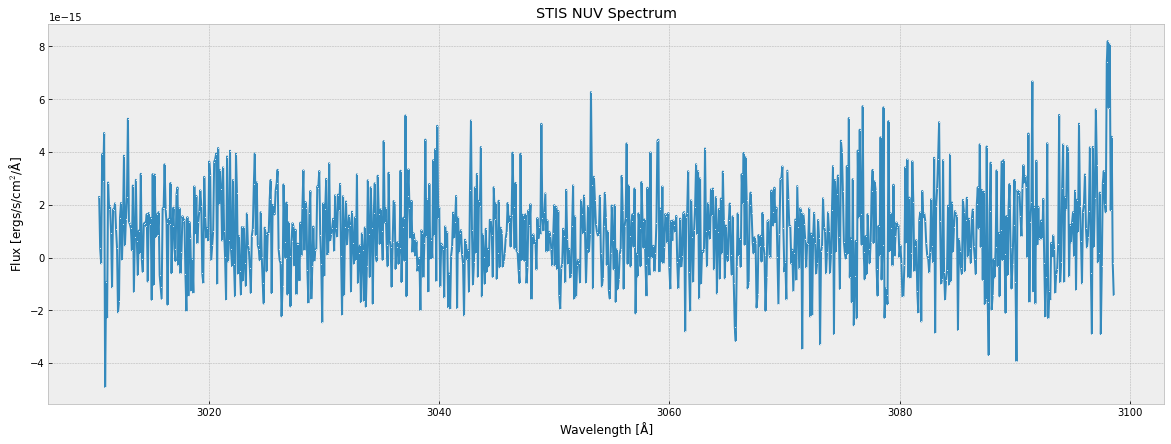

In [11]:
# make a plot of the data, use this cell to specify the format of the plot.
matplotlib.rcParams['figure.figsize'] = (20,7)
plt.style.use("bmh")

plt.plot(wl, flux, #the x-data, y-data, and y-axis error
             marker=".",markersize="2",markerfacecolor='w', markeredgewidth=0) #specifies the data points style
plt.title("STIS NUV Spectrum")
plt.xlabel('Wavelength [' + chr(197) +']')
plt.ylabel("Flux [ergs/s/cm$^2$/" + chr(197) +"]")

You can zoom in to a specific wavelength range using the plt.xlim(low,high) command

(3020.0, 3040.0)

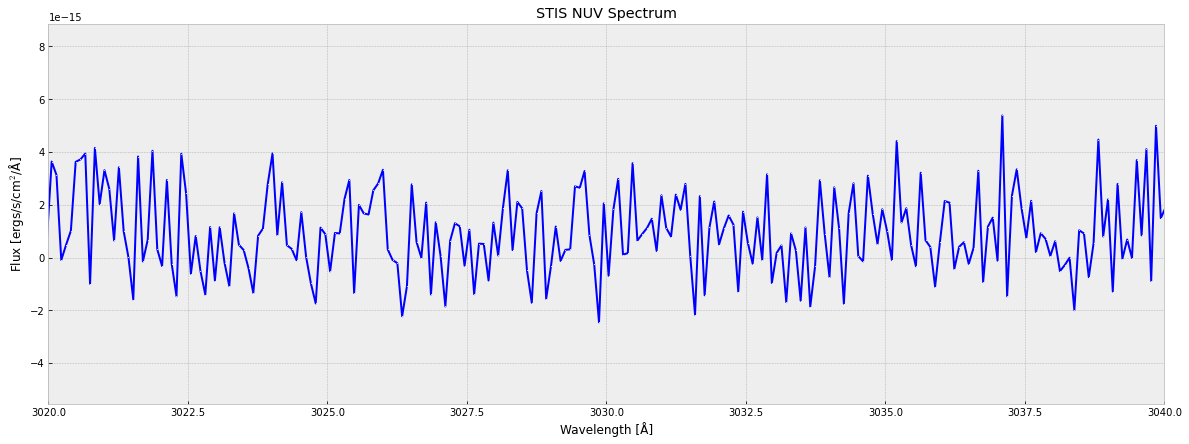

In [12]:
plt.plot(wl, flux, #the x-data, y-data, and y-axis error
             marker=".",markersize="2",markerfacecolor='w', markeredgewidth=0, #specifies the data points style
        color="blue") #specifies the format of lines
plt.title("STIS NUV Spectrum")
plt.xlabel('Wavelength [' + chr(197) +']')
plt.ylabel("Flux [ergs/s/cm$^2$/" + chr(197) +"]")
plt.xlim(3020,3040)

You can also plot the error bar together with the spectrum.

(3020.0, 3040.0)

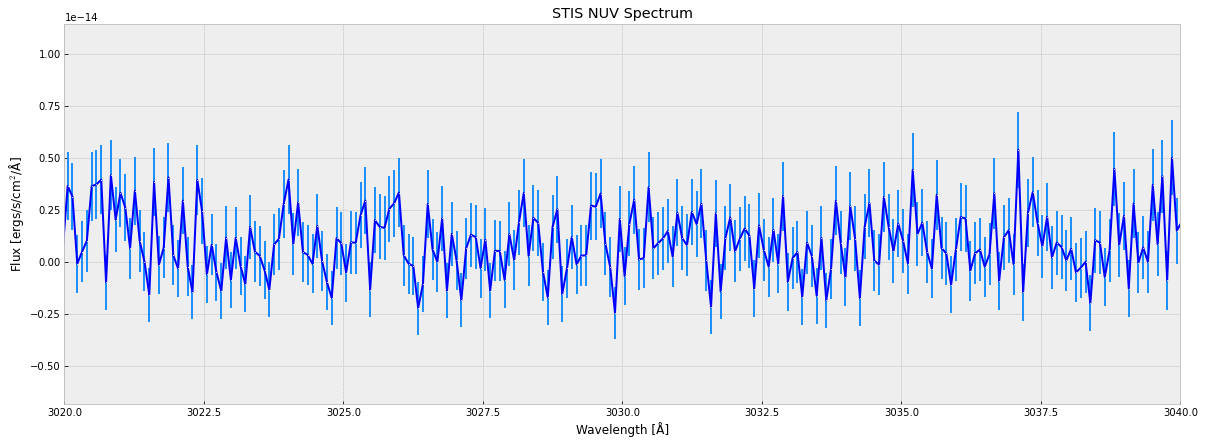

In [13]:
plt.errorbar(wl, flux, err,#the x-data, y-data, and y-axis error
             marker=".",markersize="2",markerfacecolor='w', markeredgewidth=0, #specifies the data points style
             color="blue",ecolor="dodgerblue") #specifies the format of lines and error bar
plt.title("STIS NUV Spectrum")
plt.xlabel('Wavelength [' + chr(197) +']')
plt.ylabel("Flux [ergs/s/cm$^2$/" + chr(197) +"]")
plt.xlim(3020,3040)

For more information on formatting the plots using matplotlib, see [`matplotlib.pyplot.plot`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html), [`matplotlib.pyplot.errorbar`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html).

<a id=section4></a>
## 4.Working with data quality flags

Data quality flags are assigned to each pixel in the data quality extension. Each flag has a true (set) or false (unset) state. Flagged conditions are set as specific bits in a 16-bit integer word. For a single pixel, this allows for up to 15 data quality conditions to be flagged simultaneously, using the bitwise logical OR operation. Note that the data quality flags cannot be interpreted simply as integers but must be converted to base-2 and interpreted as flags. These flags are set and used during the course of calibration, and may likewise be interpreted and used by downstream analysis applications.

<a id=section4.1></a>
### 4.1 Data quality frequencies histogram
Make a histogram according to the data quality flags, and label the bins by what each data quality values actually means.
More info: https://hst-docs.stsci.edu/stisdhb/chapter-2-stis-data-structure/2-5-error-and-data-quality-array

In [14]:
#First get the data quality flag from the x1d fits file, and convert them to log2 values
#The data quality flag is a masked array that "hides" the pixels with no data quality issue. 
#We fill those "good points" with -1 in our case
x1d_dq = x1d_data[0]["DQ"].filled(0)
dq_bits = []
for dq in x1d_dq:
    if dq == 0:
        dq_bits.append(-1)
    else:
        for b in range(0,15):
            if dq & (2**b):
                dq_bits.append(b)

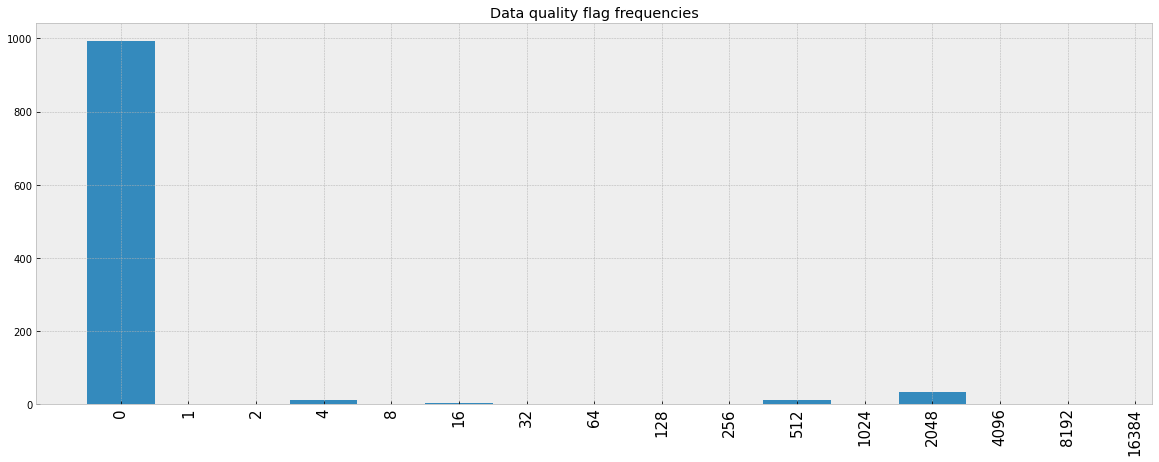

,FLAG Value,Bit Setting,Quality Condition Indicated
0,0,000000000000000,No Anomalies
1,1,000000000000001,Error in the Reed Solomon decoding
2,2,000000000000010,Lost data replaced by fill values
3,4,000000000000100,"Bad detector pixel (e.g., bad column or row, mixed science and bias for overscan, or beyond aperture)"
4,8,000000000001000,Data masked by occulting bar
5,16,000000000010000,Pixel having dark rate > 5 σ times the median dark level
6,32,000000000100000,"Large blemish, depth > 40% of the normalized p-flat (repeller wire)"
7,64,000000001000000,Vignetted pixel
8,128,000000010000000,Pixel in the overscan region
9,256,000000100000000,"Saturated pixel, count rate at 90% of max possible—local non-linearity turns over and is multi-valued; pixels within 10% of turnover and all pixels within 4 pixels of that pixel are flagged."


In [15]:
#Assign the meaning of each data quality and make the histogram
meanings = ["No Anomalies", "Error in the Reed Solomon decoding", "Lost data replaced by fill values",
           "Bad detector pixel (e.g., bad column or row, mixed science and bias for overscan, or beyond aperture)",
           "Data masked by occulting bar","Pixel having dark rate > 5 σ times the median dark level",
           "Large blemish, depth > 40% of the normalized p-flat (repeller wire)","Vignetted pixel",
           "Pixel in the overscan region",
           "Saturated pixel, count rate at 90% of max possible—local non-linearity turns over and is multi-valued; \
pixels within 10% of turnover and all pixels within 4 pixels of that pixel are flagged.",
           "Bad pixel in reference file","""Small blemish, depth between 40% and 70% of the normalized flat. \
Applies to MAMA and CCD p-flats""",
           ">30% of background pixels rejected by sigma-clip, or flagged, during 1-D spectral extraction",
           "Extracted flux affected by bad input data",
            "Data rejected in input pixel during image combination for cosmic ray rejection",
           "Extracted flux not CTI corrected because gross counts are ≤ 0"]

flags = [int(2**i) for i in range(-1,15)]
bins_ = np.arange(-1, 15)
plt.title("Data quality flag frequencies")
h = plt.hist(dq_bits,bins=bins_)
x = plt.xticks(bins_+0.5, labels=flags, rotation='vertical', fontsize=15)
plt.show()

bits = ['0'*(15-len(bin(i)[2:]))+bin(i)[2:] for i in flags]
dq_table = pd.DataFrame({"FLAG Value":flags,"Bit Setting":bits,"Quality Condition Indicated":meanings})

pd.set_option('display.max_colwidth', None)
display(dq_table)

<a id=section4.2></a>
### 4.2 Removing "Serious Data Quality"
Through the calibaration pipeline, some data qualities are marked "serious". The value of serious data qualities are marked through "SDQFLAGS". We can decompose that value according to the bits in order to see the specific data quality flags that are marked serious.

In [16]:
sdqFlags_nuv=fits.getheader(x1d_file,1)["SDQFLAGS"]
print("The SDQFLAGS is {flag}, which is in binary {bin_flag},".format(flag=sdqFlags_nuv,bin_flag=bin(sdqFlags_nuv)[2:]))
print("Therefore the following data qualities are marked \"serious\":")
for i in range(15):
    if 2**(i) & sdqFlags_nuv:
        print("\t"+str(i+1)+":" +meanings[i+1])

The SDQFLAGS is 31743, which is in binary 111101111111111,
Therefore the following data qualities are marked "serious":
	1:Error in the Reed Solomon decoding
	2:Lost data replaced by fill values
	3:Bad detector pixel (e.g., bad column or row, mixed science and bias for overscan, or beyond aperture)
	4:Data masked by occulting bar
	5:Pixel having dark rate > 5 σ times the median dark level
	6:Large blemish, depth > 40% of the normalized p-flat (repeller wire)
	7:Vignetted pixel
	8:Pixel in the overscan region
	9:Saturated pixel, count rate at 90% of max possible—local non-linearity turns over and is multi-valued; pixels within 10% of turnover and all pixels within 4 pixels of that pixel are flagged.
	10:Bad pixel in reference file
	12:>30% of background pixels rejected by sigma-clip, or flagged, during 1-D spectral extraction
	13:Extracted flux affected by bad input data
	14:Data rejected in input pixel during image combination for cosmic ray rejection
	15:Extracted flux not CTI correct

We can now remove the data points with SDQ flags. In the plots below, the first one is the same as the spectrum in which we do not handle the SDQ flags. The second one is the spectrum with SDQ flagged data removed, and the SDQ flagged data points are marked with red '+'.

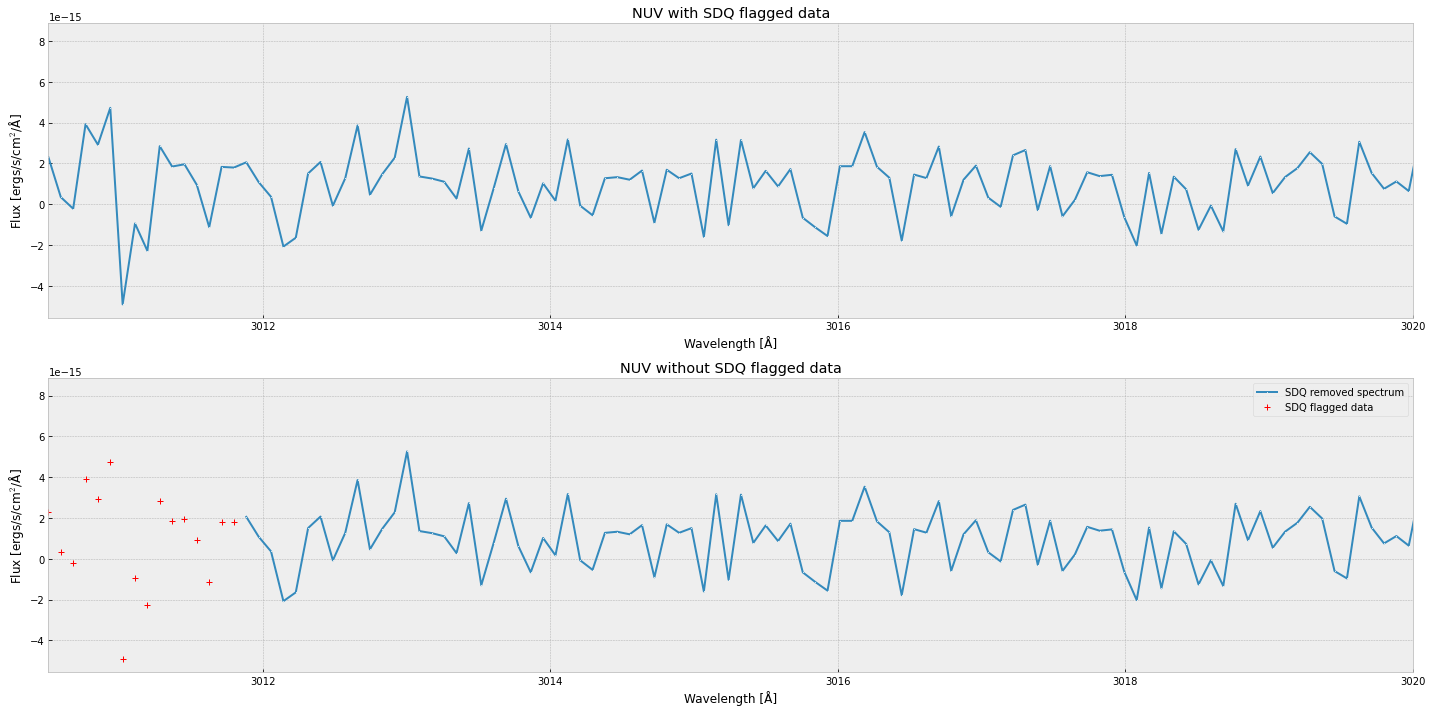

In [17]:
matplotlib.rcParams['figure.figsize'] = (20,10)
plt.style.use("bmh")

# Filter the datapoints to where there are no serious DQ flags
mask_noSDQ = np.ones(len(x1d_data[0]["WAVELENGTH"]),dtype=bool)
for i in range(0,len(x1d_data[0]["WAVELENGTH"])):
    if x1d_data[0]["DQ"][i] & sdqFlags_nuv:
            mask_noSDQ[i]=False
# get the spectrum without SDQ using the mask we just created
wvln_noSDQ, flux_noSDQ,err_noSDQ = x1d_data[0]["WAVELENGTH"][
    mask_noSDQ], x1d_data[0]["FLUX"][mask_noSDQ],x1d_data[0]["ERROR"][mask_noSDQ]
# inverse the _noSDQ mask to collect the data points with SDQ flags
mask_SDQ = [not elem for elem in mask_noSDQ]
wvln_SDQ, flux_SDQ = x1d_data[0]["WAVELENGTH"][mask_SDQ], x1d_data[0]["FLUX"][mask_SDQ]

# plot1: the spectrum with SDQ flagged data included
plt.subplot(2,1,1)
plt.plot(wl, flux, #the x-data, y-data, and y-axis error
             marker=".",markersize="2",markerfacecolor='w', markeredgewidth=0) #specifies the data points style
plt.title("NUV with SDQ flagged data")
plt.xlabel('Wavelength [' + chr(197) +']')
plt.ylabel("Flux [ergs/s/cm$^2$/" + chr(197) +"]")
plt.xlim(min(wl),3020)

# plot2: plot the spectrum without SDQ flagged data, then mark the SDQ data points with +
plt.subplot(2,1,2)
# Plot the filtered datapoints
plt.plot(wvln_noSDQ, flux_noSDQ, #the x-data, y-data, and y-axis error
             marker=".",markersize="2",markerfacecolor='w', markeredgewidth=0,label="SDQ removed spectrum")
plt.plot(wvln_SDQ, flux_SDQ,'r+',label="SDQ flagged data")
plt.xlim(min(wl),3020)
plt.legend()

# Format the figure
plt.title("NUV without SDQ flagged data")
plt.xlabel('Wavelength [' + chr(197) +']')
plt.ylabel("Flux [ergs/s/cm$^2$/" + chr(197) +"]")
plt.tight_layout()

<a id=section5></a>
## 5. Visualizing STIS Image

The STIS images are stored as two-dimensional arrays in FITS image extension files. For more information on STIS image files and extension, see [STIS FITS Image Extension Files](https://hst-docs.stsci.edu/stisdhb/chapter-2-stis-data-structure/2-3-stis-file-structures#id-2.3STISFileStructures-2.3.12.3.1STISFITSImageExtensionFiles)

<a id=section5.1></a>
### 5.1 Exploring image file structure
The rectified, wavelength and flux calibrated first order spectra or Geometrically corrected imaging data is stored in the fits file with the x2d extension. Similar to what we did to the x1d file, we first open the fits file to explore its file structure.

In [18]:
#read in the x2d file and get its info
x2d_file=Path("./data/mastDownload/HST/odgxt9010/odgxt9010_x2d.fits")
fits.info(x2d_file)

Filename: data/mastDownload/HST/odgxt9010/odgxt9010_x2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     281   ()      
  1  SCI           1 ImageHDU       120   (1201, 1201)   float32   
  2  ERR           1 ImageHDU        61   (1201, 1201)   float32   
  3  DQ            1 ImageHDU        44   (1201, 1201)   int16   


- The first, of extension type SCI, stores the science values.
- The second, of extension type ERR, contains the statistical errors, which are propagated through the calibration process. It is unpopulated in raw data files.
- The third, of extension type DQ, stores the data quality values, which flag suspect pixels in the corresponding SCI data. It is unpopulated in raw data files.

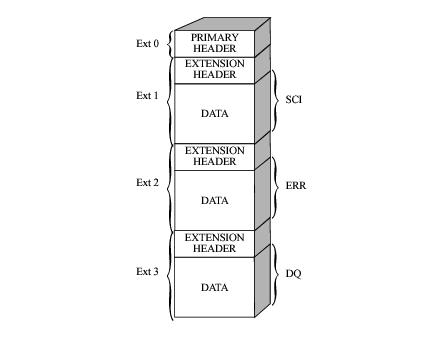

Similarly, we can also get the header from this fits file to see the scientific metadata.

In [19]:
#get header of the fits file
x2d_header = fits.getheader(x2d_file,0)

<a id=section5.2></a>
### 5.2 Showing the image
Now we collect the science image data from the fits file and show the image.

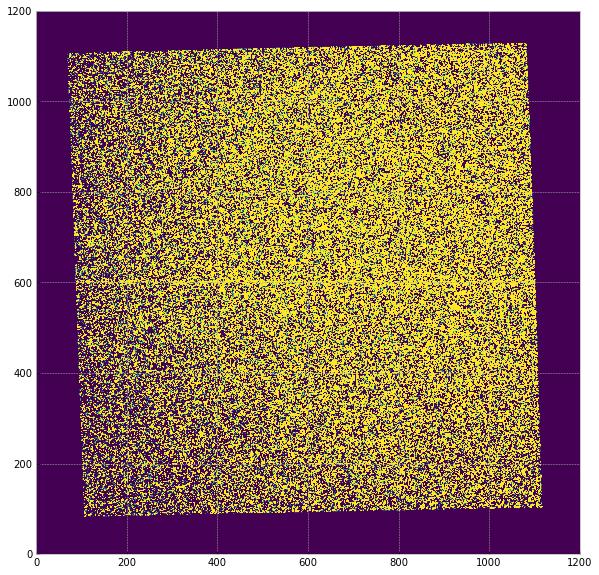

In [20]:
#get data as a numpy array
with fits.open(x2d_file) as hdu_list:
    x2d_data = hdu_list[1].data
# show the image
# We normalize the color of each pixel to a specific range through vmin and vmax. 
# This value typically matches the magnitude of the x2d data, but can be changed to get better imaging result
plt.imshow(x2d_data,origin='lower',vmin=0,vmax=1e-14,cmap="viridis")

<a id=section5.3></a>
### 5.3 Removing serious data quality pixels

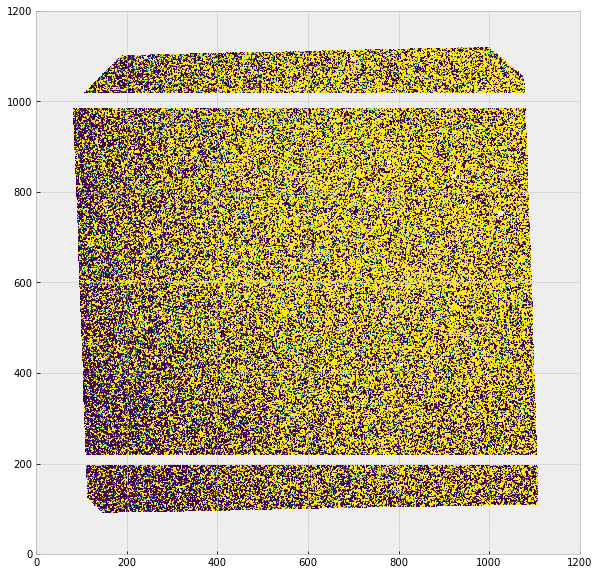

In [21]:
# get the serious data quality flag
sdqFlags_nuv=fits.getheader(x2d_file,1)["SDQFLAGS"]
# get data quality flags of each pixels
with fits.open(x2d_file) as hdu_list:
    x2d_dq = hdu_list[3].data
# create a mask of bad pixels and set them to nan
def check_dq(dq):
    return bool(dq & sdqFlags_nuv)
mask = np.vectorize(check_dq)(x2d_dq)
x2d_mask = np.ma.array(x2d_data,mask=mask,fill_value=np.nan)
# plot the image
plt.imshow(x2d_mask,origin='lower',vmin=0,vmax=1e-14,cmap="viridis")

<a id=section6></a>
## 6.Working with Time-Tag data

The MAMA detecters have a unique Time-Tag mode besides ACCUM mode. TIME-TAG mode is used for high-time-resolution spectroscopy and imaging in the UV. In TIME-TAG mode, the position and detection time of every photon is recorded in an event list. The Time-Tag mode operation for the MAMA detectors can be found at: [MAMA TIME-TAG Mode](https://hst-docs.stsci.edu/stisihb/chapter-11-data-taking/11-1-basic-operating-modes#id-11.1BasicOperatingModes-Section11.1.311.1.3MAMATIME-TAGMode).

In TIME-TAG mode, the position and detection time of every photon is recorded in an event list.
First collect the _tag data:

In [22]:
# Search target objscy by obs_id
target = Observations.query_criteria(obs_id='odgxt9010')
# get a list of files assiciated with that target
NUV_list = Observations.get_product_list(target)
# Download only the SCIENCE fits files
Observations.download_products(NUV_list,productType="AUXILIARY",extension='fits',download_dir=str(datadir))

INFO: Found cached file data/mastDownload/HST/odgxt9010/odgxt9010_jif.fits with expected size 34560. [astroquery.query]
INFO: Found cached file data/mastDownload/HST/odgxt9010/odgxt9010_jit.fits with expected size 103680. [astroquery.query]
INFO: Found cached file data/mastDownload/HST/odgxt9010/odgxt9010_jwf.fits with expected size 25920. [astroquery.query]
INFO: Found cached file data/mastDownload/HST/odgxt9010/odgxt9010_jwt.fits with expected size 20160. [astroquery.query]
INFO: Found cached file data/mastDownload/HST/odgxt9010/odgxt9010_spt.fits with expected size 241920. [astroquery.query]
INFO: Found cached file data/mastDownload/HST/odgxt9010/odgxt9010_tag.fits with expected size 48064320. [astroquery.query]
INFO: Found cached file data/mastDownload/HST/odgxt9010/odgxt9010_trl.fits with expected size 37440. [astroquery.query]
INFO: Found cached file data/mastDownload/HST/odgxt9010/odgxt9010_wav.fits with expected size 4262400. [astroquery.query]
INFO: Found cached file data/mast

Local Path,Status,Message,URL
str50,str8,object,object
data/mastDownload/HST/odgxt9010/odgxt9010_jif.fits,COMPLETE,None,None
data/mastDownload/HST/odgxt9010/odgxt9010_jit.fits,COMPLETE,None,None
data/mastDownload/HST/odgxt9010/odgxt9010_jwf.fits,COMPLETE,None,None
data/mastDownload/HST/odgxt9010/odgxt9010_jwt.fits,COMPLETE,None,None
data/mastDownload/HST/odgxt9010/odgxt9010_spt.fits,COMPLETE,None,None
data/mastDownload/HST/odgxt9010/odgxt9010_tag.fits,COMPLETE,None,None
data/mastDownload/HST/odgxt9010/odgxt9010_trl.fits,COMPLETE,None,None
data/mastDownload/HST/odgxt9010/odgxt9010_wav.fits,COMPLETE,None,None
data/mastDownload/HST/odgxt9010/odgxt9010_wsp.fits,COMPLETE,None,None


<a id=section6.1></a>
### 6.1 Investigating the _tag data

In [23]:
# get info about the tag extension fits file
tag = Path("./data/mastDownload/HST/odgxt9010/odgxt9010_tag.fits")
fits.info(tag)

Filename: data/mastDownload/HST/odgxt9010/odgxt9010_tag.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     218   ()      
  1  EVENTS        1 BinTableHDU    147   4802131R x 4C   [1J, 1I, 1I, 1I]   
  2  GTI           1 BinTableHDU     22   1R x 2C   [1D, 1D]   


The _tag fits file has two binary table extensions: EVENTS and GTI.

In [24]:
# get header of the EVENTS extension
# print only the TIMETAG EVENTS TABLE COLUMNS (line 130-147)
fits.getheader(tag,1)[130:147]

                                                                                
              / TIMETAG EVENTS TABLE COLUMNS                                    
                                                                                
TTYPE1  = 'TIME    '           / event clock time                               
TFORM1  = '1J      '           / data format for TIME: 32-bit integer           
TUNIT1  = 'seconds '           / units for TIME: seconds                        
TSCAL1  =             0.000125 / scale factor to convert s/c clock ticks to sec 
TZERO1  =                  0.0 / TIME zero point: starting time of obs.         
TTYPE2  = 'AXIS1   '           / Doppler corrected axis 1 detector coordinate   
TFORM2  = '1I      '           / data format for AXIS1: 16-bit integer          
TUNIT2  = 'pixels  '           / physical units for AXIS1: pixels               
TTYPE3  = 'AXIS2   '           / axis 2 detector coordinate                     
TFORM3  = '1I      '        

Columns in the EVENTS extension:
- TIME: the time each event was recorded relative to the start time
- DETAXIS1: pixel coordinate along the spectral axis without the correction for Doppler shifts
- AXIS2: pixel coordinate along the spatial axis
- DETAXIS1: pixel coordinate along the spectral axis without the corretion term on Doppler shifts

In [25]:
# get header of the GTI extension
fits.getheader(tag,2)

XTENSION= 'BINTABLE'           / extension type                                 
BITPIX  =                    8 / bits per data value                            
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                   16 / length of first data axis                      
NAXIS2  =                    1 / length of second data axis                     
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    2 / number of fields in each table row             
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'GTI     '           / extension name                                 
EXTVER  =                    1 / extension version number                       
ROOTNAME= 'odgxt9010                         ' / rootname of the observation set
EXPNAME = 'odgxt9rfq        

Columns in the GTI extension:
- START: start of good time interval
- STOP: end of good time interval

<a id=section6.2></a>
### 6.2 Converting Time_Tag into ACCUM image
Time tag data can be converted into ACCUM image using the inttag method in stistools.
More information: [Error and Data Quality Array](https://stistools.readthedocs.io/en/latest/inttag.html)

In [26]:
# define the output file directory
accum = "./data/mastDownload/HST/odgxt9010/odgxt9010_accum.fits"
# convert Time_Tag into ACCUM
# the first parameter is the path to the _tag fits file, the second parameter is the output directory
stistools.inttag.inttag(tag, accum)

imset: 1, start: 0.022625, stop: 2380.222, exposure time: 2380.199375


Then the output file is in the same structure as a STIS image fits file, which we can open and plot in the same way we explored above:

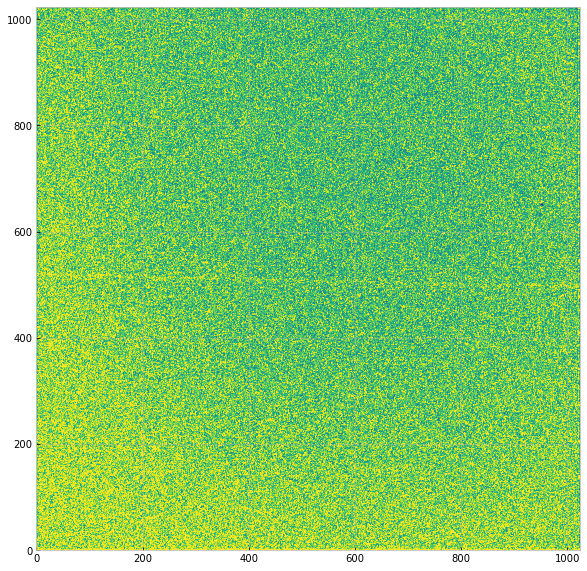

In [27]:
with fits.open(accum) as hdul:
    im = hdul[1].data
plt.imshow(im,origin='lower',vmin=0,vmax=6,cmap="viridis")

inttag with multiple data sets: rcount specifies the number of imsets, imcrements specifies the time interval for each imsets in seconds

In [28]:
stistools.inttag.inttag(tag,accum, rcount = 5, increment = 400)
fits.info(accum)

imset: 1, start: 0.022625, stop: 400.022625, exposure time: 400.0
imset: 2, start: 400.022625, stop: 800.0226250000001, exposure time: 400.00000000000006
imset: 3, start: 800.0226250000001, stop: 1200.022625, exposure time: 400.0
imset: 4, start: 1200.022625, stop: 1600.022625, exposure time: 400.0
imset: 5, start: 1600.022625, stop: 2000.022625, exposure time: 400.0
Filename: ./data/mastDownload/HST/odgxt9010/odgxt9010_accum.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     218   ()      
  1  SCI           1 ImageHDU       138   (1024, 1024)   float64   
  2  ERR           1 ImageHDU       138   (1024, 1024)   float64   
  3  DQ            1 ImageHDU       139   ()      
  4  SCI           2 ImageHDU       138   (1024, 1024)   float64   
  5  ERR           2 ImageHDU       138   (1024, 1024)   float64   
  6  DQ            2 ImageHDU       139   ()      
  7  SCI           3 ImageHDU       138   (1024, 1024)   float64   
  8  ERR  

The output file is a series of extensions with each imset having a SCI, ERR, and DQ extension, as shown above.


---
## About this Notebook
**Author:** [Keyi Ding](kding@stsci.edu)

**Updated On:** 2022-07-18


> *This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*
## Citations

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `astropy`/`numpy`/`matplotlib`](https://www.scipy.org/citing.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

---

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 
